# *Bayesian A/B Testing and Conjugate Priors*

*Chris (with credit to Frank B. and Mark L.)*

### Objectives: answer the following

 * Be able to decribe:
     * a prior distribution
     * a likelihood function
     * a posterior distribution
     * a conjugate prior
 * Describe how a conjugate prior makes Bayesian updating easier
 * Describe how does this applies to **A/B testing**?
 * What are some key differences between frequentist and Bayesian A/B testing?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

from scipy import stats

from bayes import Bayes         # for Coin Example

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})

## Review of Frequentist Hypothesis Testing and P-values

#### Steps for frequentist hypothesis testing:

1. Define your null hypothesis (H0).
2. Define the alpha (significance) cutoff.
3. Determine how many samples you'll need for a given effect size and significance level (the power).
3. Collect data.
4. Compute the appropriate statistic (e.g. the t-statistic).
5. Compute the probability of that statistic (or something more rare) under the null hypothesis. (aka, the p-value)
6. "Reject" or "fail to reject" the null hypothesis.

#### Concept of P-value

"*The probability of observing data at least as extreme as the observation given the null hypothesis*"

#### Example

Say our company goal is to have our website generate new users with a conversion rate of 10%. Let's do a hypothesis test to see if we are hitting our goal.

**Step 1:**

Define the null hypothesis as "the conversion rate is 10%", i.e. $\mu = 0.1$  Alternate, "the conversion rate is not 10%" $\mu \ne 0.1$

In [2]:
null_hypot_mu = 0.1

**Step 2:**

Define the significance level (alpha cutoff). We'll use the typical 5% type-I error rate, and choose a two-tailed test.

In [3]:
alpha_cutoff = 0.05

**Step 3:**

The data is a series of bernoulli trials (a binomial distribution)- either a person converts or they don't.  The Null hypothesis is the proportion that convert, p, is 0.1, of 1 in 10.  

Need a power calculation for 2-sided one-sample binomial test.

Oh look.  [Here](http://powerandsamplesize.com/Calculators/Other/1-Sample-Binomial) is a one-sample binomial test power calculator.  Let's use it with an effect size of 1% (0.01).

In [4]:
# from the calculator
n = 7670

**Step 4:**

Collect data. Here it is:

In [5]:
from math import ceil

samples_50 = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
              0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

multiples = ceil(n / len(samples_50))

samples = multiples * samples_50
# the code above makes multiple identical copies of the list - just one way of making toy data

print("# samples:  ", len(samples))
print("sample mean:", np.mean(samples))

# samples:   7700
sample mean: 0.08


**Step 5 and 6:**  
 

The [binomial test](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.binom_test.html) tests whether a proportion (such as the mean number of clicks) is equal to some value.  

In [6]:
#from scipy.stats import binom_test

p_value = stats.binom_test(samples.count(1), len(samples), null_hypot_mu)
# successes, number of trials, the proportion you are checking it against)
print(f"The p_value is {p_value:0.3e}.")

The p_value is 1.885e-09.


C:\Users\Smith\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


**Step 6:**

In [7]:
if p_value < alpha_cutoff:
    print("REJECT null hypothesis! (i.e. this data is unusual enough under the null that we reject the null)")
else:
    print("FAIL TO REJECT null hypothesis (i.e. not enough evidence to reject)")

REJECT null hypothesis! (i.e. this data is unusual enough under the null that we reject the null)


### A dream of frequentist hypothesis testing

Wouldn’t it be nice if, instead, we could give a **probability** of probability, rather than *yes* or *no*, of a ***hypothesis*** given the ***data***?


##  A quick summary of two schools (again)

### What's in a Frequentist?

A frequentist subscribes to what is now called "classical statistics". Frequentists define _probability_ as:

```
Probability:
------------
The relative frequency of occurrence of an experiment's outcome as the number of trials
approaches infinity. This is usually referred to as the "long run" frequency of an event.
```

i.e.

$$P(x) = \lim_{n_t \to \infty} \dfrac{n_x}{n_t}$$

where $n_t$ is the number of trials and $n_x$ is the number of trials where the outcome is $x$.

**Most importantly:** Frequentists do hypothesis testing and talk about p-values.

Read more [here](https://en.wikipedia.org/wiki/Probability#Interpretations) and [here](https://en.wikipedia.org/wiki/Frequentist_probability).

### The Bayesian Way

"Probability is what you _believe_."


Sound subjective? ... Well, it is! Bayesians agree, to some extent. More on that later.

**The Bayesian way** is to start with a belief, then update your belief as you see evidence. Then update your belief again as you see more evidence. Etc.

For example (using my beliefs):

$$
\begin{align*}
&P(\text{it rained last night}) = 0.15 \\
&P(\text{it rained last night} \, \, | \, \, \text{I am in LA}) = 0.01 \\
&P(\text{it rained last night} \, \, | \, \, \text{I am in LA and the ground is dry}) = 0.001
\end{align*}
$$

Read more [here](https://en.wikipedia.org/wiki/Probability#Interpretations) and [here](https://en.wikipedia.org/wiki/Bayesian_probability).

# Bayes' Theorem

Imagine we have a discrete set of hypotheses $\{H_i\}$
- e.g., $H_1: X \sim \text{Poisson}(2) \\ H_2: X \sim \text{Poisson}(5)$

Recall **Bayes' Theorem**

$$P(A|B) = \frac{P(B|A) P(A)}{P(B)}$$

When we use it in the context of statistics, we talk about the probability that a hypothesis $H_i$ is true given some observed sample $x$.

$$P(H_i\ |\ x) = \frac{P(x\ |\ H_i) P(H_i)}{P(x)}$$

where

 * $P(H_i\ |\ x)$ is the **posterior probability distribution** of hypothesis $H_i$ being true, given observed data $x$
 * $P(x\ |\ H_i)$ is the probability of observing $x$ given $H_i$, also called the **likelihood**
 * $P(H_i)$ is the **prior distribution** of $H_i$, defined before we observe any data
 * $P(x)$, the **normalizing constant**, is

$$P(x) = \sum_{i} P(x\ |\ H_i) P(H_i)$$

<br> 

If we had a ***continuous*** family of hypotheses, such as $H(\theta): X \sim \text{Normal}(\theta,1),\  \theta \in \mathfrak{R}$, then we'd express Bayes' theorem in terms of probability ***densities*** instead:

$$f_{\theta|X}(\theta) = \frac{f_{X | \theta}(x) f_\theta(\theta)}{f_{X}(x)}$$

where

 * $f_{\theta|X}(\theta)$ is the **posterior probability distribution** of the parameter $\theta$ given observed data $x$
 * $f_{X | \theta}(x)$ is the probability density function of $X$ evaluated at $x$, given the parameter value $\theta$ 
  - also called the **likelihood** function $\mathcal{L}(\theta)$
 * $f_\theta(\theta)$ is the **prior probability distribution** of $\theta$, defined before we observe any data
 * $f_{X}(x)$, the **normalizing constant**, is

$$f_{X}(x) = \int_{-\infty}^{\infty} f_{X | \theta}(x) f_\theta(\theta) d\theta$$

##### What's the moral here?
## $$\text{posterior}(\theta) \propto \text{likelihood}(\theta; x)\times \text{prior}(\theta)$$

# Example: The Unknown Coin

Data is generated by the random variable $X$, which takes on the values 0 (tails) or 1 (heads)

$H: X \sim \text{Bernoulli}(p)$

This defines a *family* of hypotheses parametrized by $p$, the "fairness" of the coin.

Revisiting this morning's coin:

In [8]:
# here we're discretizing the heads probability p
p = np.linspace(0, 1, 101)
p

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [9]:
p_priors = { k:1/101 for k in p} #Uniform

In [10]:
def coin_likelihood(data, p):
    # what is the likelihood of drawing data
    # given that the heads probability is p
    # data = 0 for tails, 1 for heads
    if data:
        return p
    return 1-p

Now create an instance of that same `Bayes` object from this morning

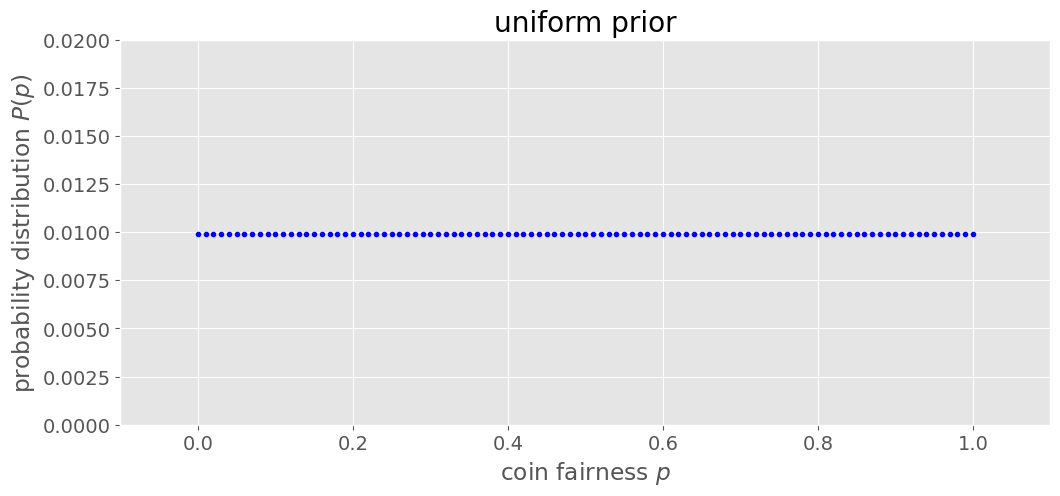

In [11]:
fig, ax = plt.subplots(figsize=(12,5))
bayes = Bayes(p_priors.copy(), coin_likelihood)
bayes.plot(title="uniform prior", color='b', marker='.', linestyle='')
ax.set_ylim([0,0.02])
ax.set_xlim([-0.1,1.1])
ax.set_xlabel('coin fairness $p$')
ax.set_ylabel('probability distribution $P(p)$');

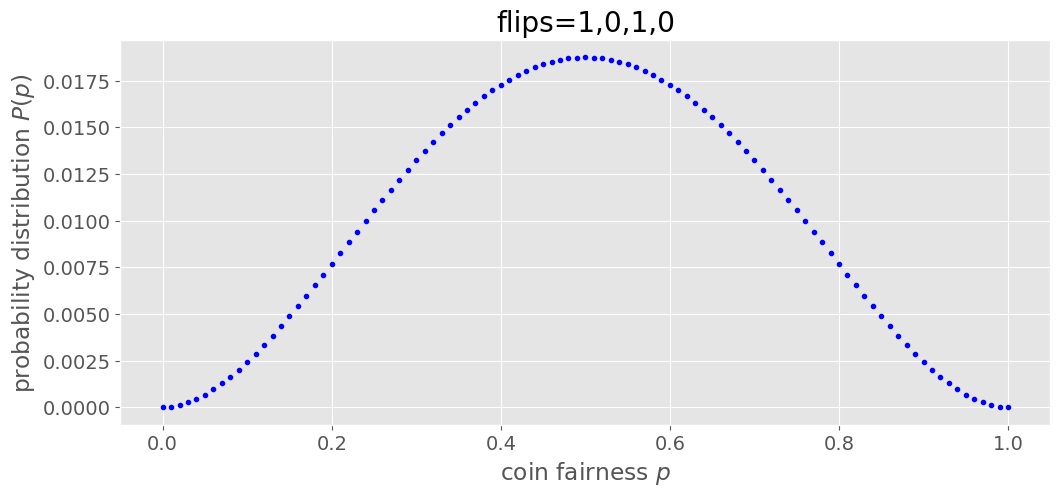

In [12]:
bayes.update(1) 
bayes.update(0) 
bayes.update(1)
bayes.update(0)

fig, ax = plt.subplots(figsize=(12,5))

bayes.plot(title="flips=1,0,1,0", color='b', marker='.', linestyle='')
plt.xlabel('coin fairness $p$')
plt.ylabel('probability distribution $P(p)$');

In [13]:
#Create a function to do this a little more nicely:
def feed_bayes_and_plot(bayes, data_sequence):
    N = len(data_sequence)
    
    fig, axs = plt.subplots(1, N, figsize=(16, 3))
    
    # for each new data point
    for i, ax in enumerate(axs.flatten()):
        bayes.update(data_sequence[i])
        sorted_keys = sorted(bayes.prior.keys())
        sorted_probs = [bayes.prior[key] for key in sorted_keys]
        ax.plot(sorted_keys, sorted_probs, color='b', marker='.', linestyle='')
        ax.set_title("Observed:\n" + ",".join(map(str,data_sequence[0:i+1])))
        ax.get_yaxis().set_ticks([])
        if i==0:
            ax.set_ylabel('$P(p)$')
        ax.set_xlabel('$p$')

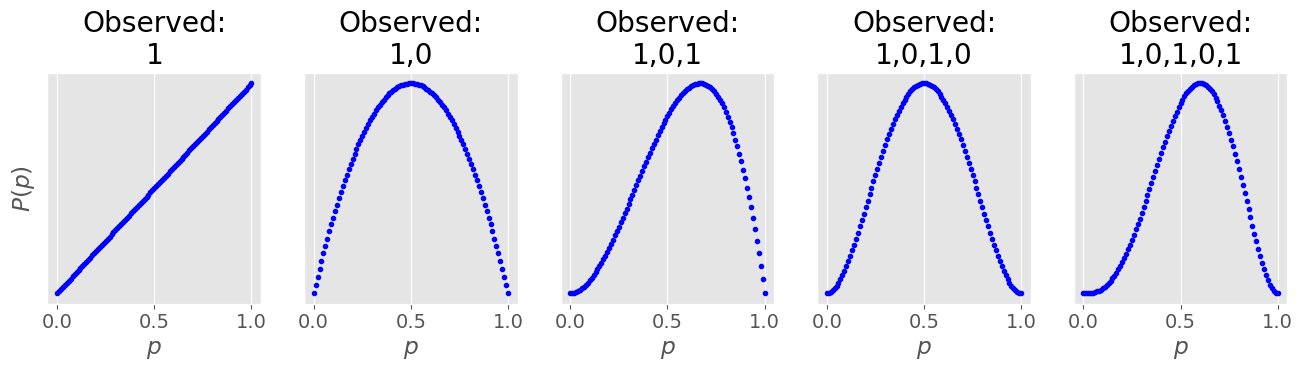

In [14]:
flips_A = [1,0,1,0,1]

bayesA = Bayes(p_priors.copy(), coin_likelihood)
feed_bayes_and_plot(bayesA, flips_A)

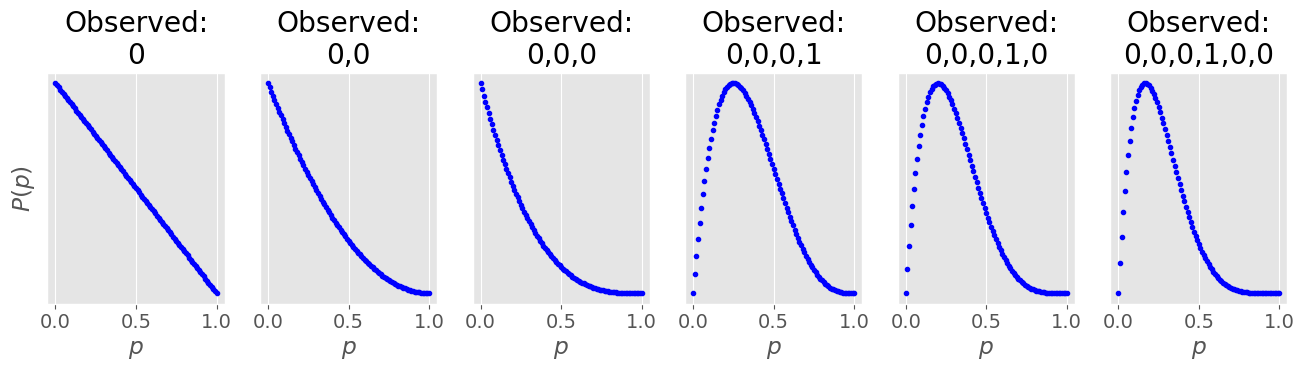

In [15]:
flips_B = [0,0,0,1,0,0]

bayesB = Bayes(p_priors.copy(), coin_likelihood)
feed_bayes_and_plot(bayesB, flips_B)

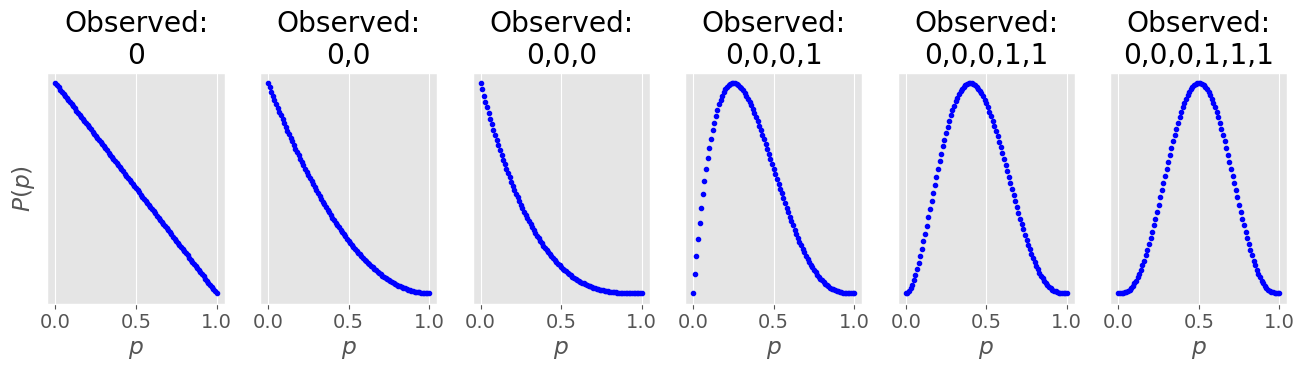

In [16]:
flips_C = [0,0,0,1,1,1]

bayesC = Bayes(p_priors.copy(), coin_likelihood)
feed_bayes_and_plot(bayesC, flips_C)

# Click-through rates (CTR)

Say we have a website. When a user visits the home page, they either click `Buy now!` or they leave. We can think of each user as a draw from the same Bernoulli distribution: there's a probability $p$ that they click `Buy now!`. 

Our site goes live, we collect data on how many people viewed the site and how many clicked through. How can we get a probabilistic estimate of the parameter $p$ that defines this stochastic process?

Well heck, this is identical to the coin example above. Let's work with this from now on.

### $$\text{posterior}(p) \propto \text{likelihood}(p; x)\times \text{prior}(p)$$

- Our goal is to find an analytical form for the posterior probability distribution over $p$
- To do so, we’re going to model each of these terms with an appropriate distribution. 
- We’ll see that it makes Bayesian updating easy and fun! 

## Likelihood: what generated our data?

Say we collected data from $n$ users and $k$ of them clicked through.

Let our random variable $X$ be **the number of successes in $n$ trials**. Then our data produced a single draw from a binomial distribution
$$ \begin{align} P(X=k\ |\ p, n) &= {n \choose k} p^k (1-p)^{n-k}  \\&= \mathcal{L}(p) \end{align}$$


### $$\text{posterior}(p) \propto \color{blue}{\text{binomial}(k;p,n)}\times \text{prior}(p)$$


## Prior: hmm...

- We want to pick a distribution for $p$, so it must be defined over $[0,1]$. But that's pretty much our only constraint.
- We could come up with any arbitrary probability distribution, call it our prior, and be done. But remember, this Bayesian updating business is computationally expensive. If there's a particular form for the prior distribution that makes ***Bayesian updating trivially simple***, without having to evaluate a complicated function, we want to use it.

#### Let's look at the binomial distribution again
$$ P(k\ |\ p, n) = {n \choose k} p^k (1-p)^{n-k} $$

Can we make a probability distribution over $p$ that has the same form?

$$ \text{sure_would_be_nice_distribution}(p; a, b) \sim p^a (1-p)^b $$

This way the prior would be easy to update (calculate the new posterior) whenever we get new evidence/data without having to do complex math.

Oh someone already came up with this: the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)

$$ \text{Beta}(p; \alpha, \beta): \ f_p(p) = \frac{p^{\alpha - 1}(1-p)^{\beta - 1}}{\text{B}(\alpha, \beta)}  $$

$\alpha$ and $\beta$ are the parameters of the beta distribution. (That B in the bottom is the normalization constant that keeps the area under the curve equal to 1.) How do they define the shape of the pdf?

$ \text{E}[p] = \frac{\alpha}{\alpha + \beta}$ ; $ \text{Mode} = \frac{\alpha - 1}{\alpha + \beta - 2}$

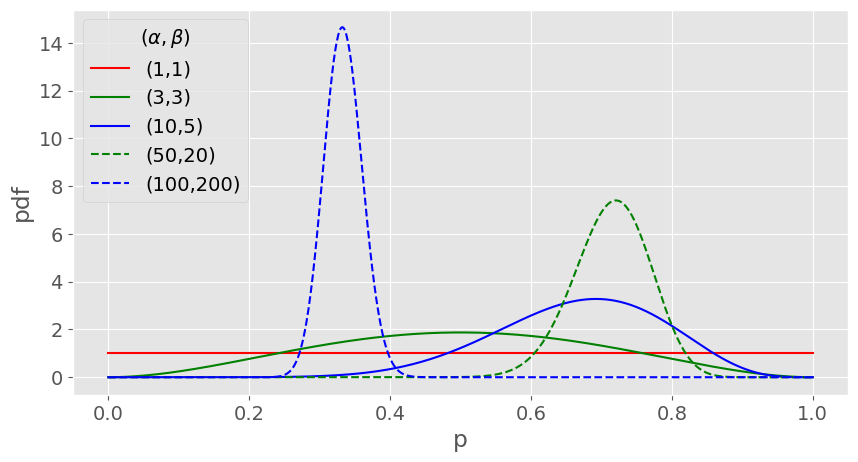

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
x = np.linspace(0,1,1000)
for (a,b,s) in [(1,1,"r-"), (3,3,"g-"), (10,5,"b-"), 
                (50,20,"g--"), (100,200,"b--")]:
        ax.plot(x,
                stats.beta(a,b).pdf(x),
                s,
                label="({0},{1})".format(a,b))
ax.legend(title=r"($\alpha,\beta$)", loc="upper left")
ax.set_xlabel("p")
ax.set_ylabel("pdf");

note that $\alpha = 1, \beta = 1$ is the $\text{uniform}(0,1)$ distribution

also note that $\alpha \gt \beta$ means that the peak of the pdf is at some $p > 0.5$

#### Get MORE feel for beta distribution
credit: frank

In [18]:
def plot_beta(alpha, beta, ax, title=None, label=None, xticks=[0.0, 0.5, 1.0]):

    # Build a beta distribtuion scipy object.
    dist = stats.beta(alpha, beta)

    # The support (always this for the beta dist).
    x = np.linspace(0.0, 1.0, 201)

    # The probability density at each sample support value.
    y = dist.pdf(x)

    # Plot it all.
    lines = ax.plot(x, y, label=label)
    ax.fill_between(x, y, alpha=0.2, color=lines[0].get_c())
    if title: 
        ax.set_title(title)
    ax.get_yaxis().set_ticks([])
    #ax.get_yaxis().set_ticks([np.max(y)])
    ax.get_xaxis().set_ticks(xticks)
    ax.set_ylim(0.0, np.max(y)*1.2)

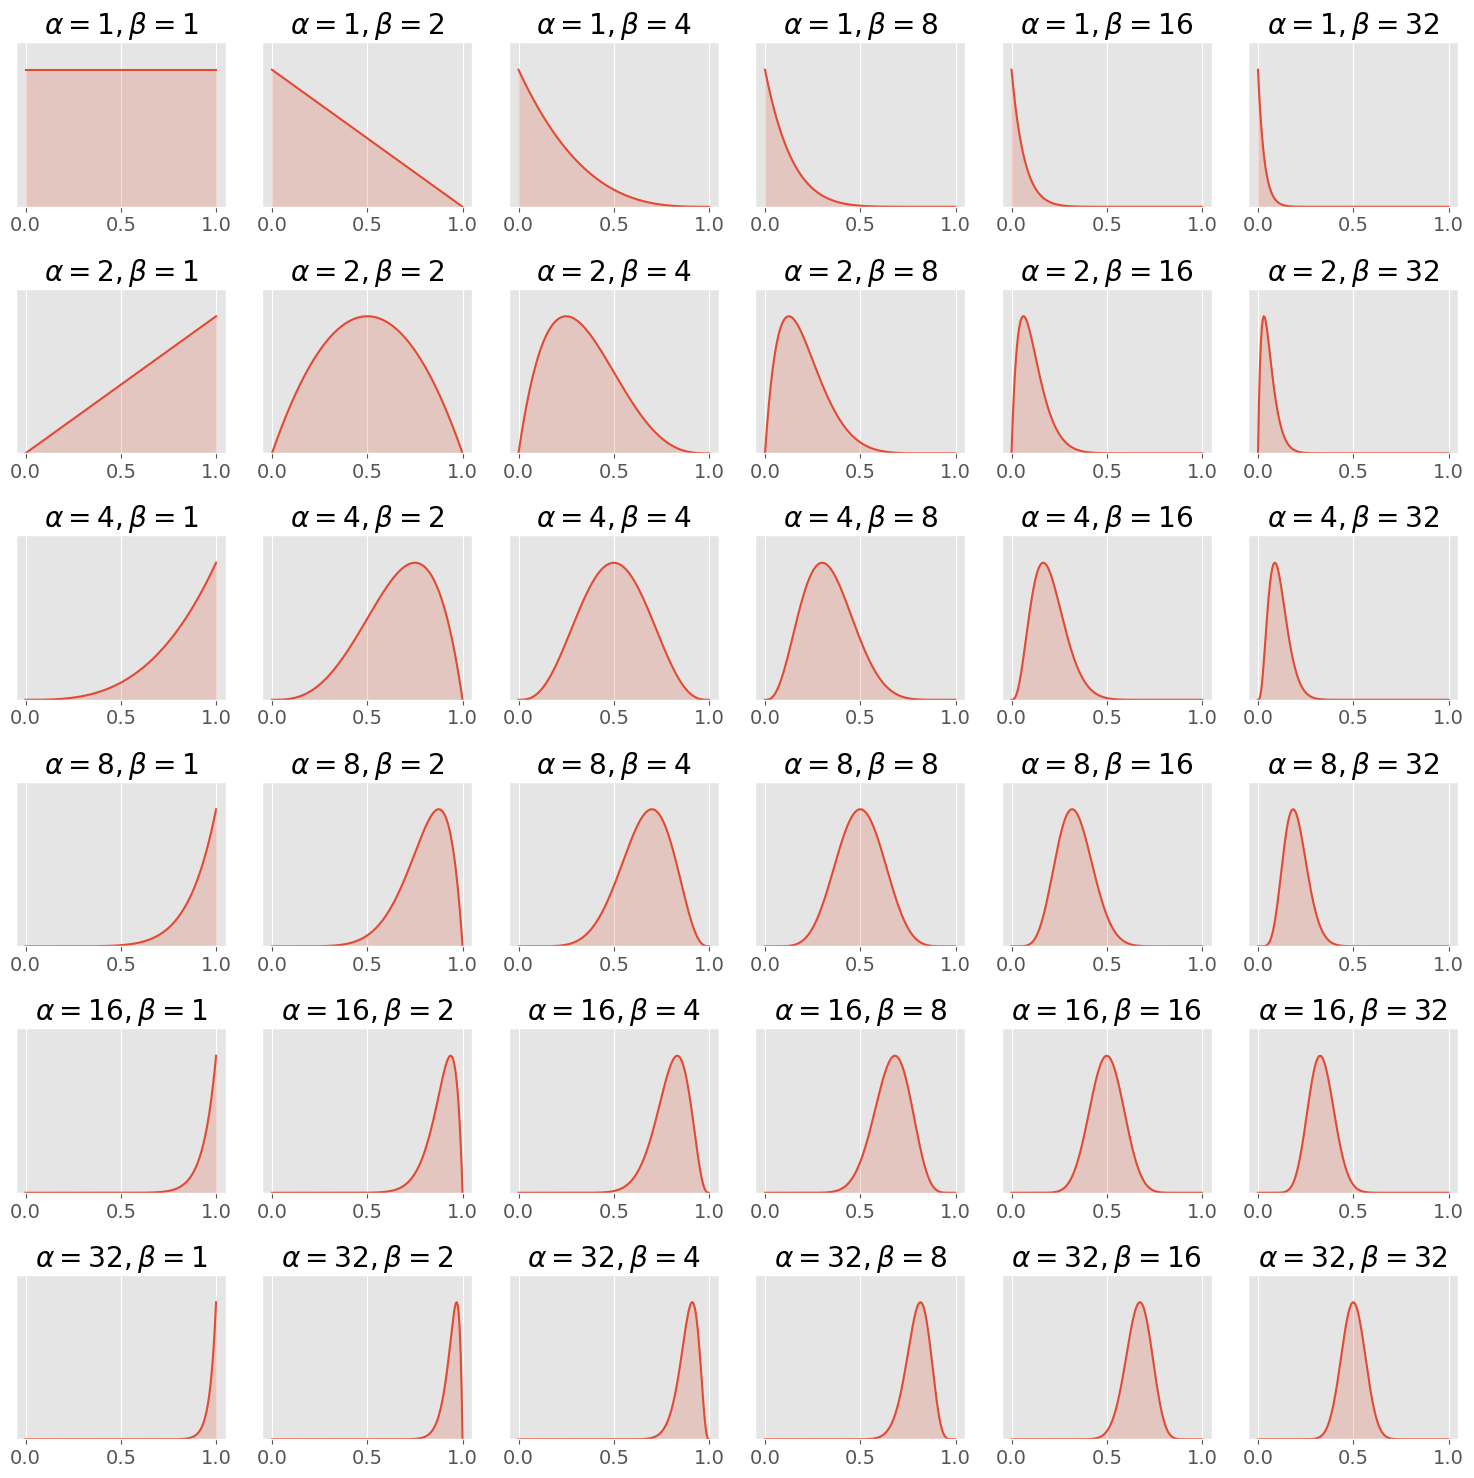

In [19]:
# The shape parameters.
alpha_values = [1, 2, 4, 8, 16, 32]  
beta_values  = [1, 2, 4, 8, 16, 32]
n_rows, n_cols = len(alpha_values), len(beta_values)
alpha_beta_pairs = ( (i, j) for i in alpha_values for j in beta_values )

# Create a large figure - nice way to do it.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

# Plot each beta dist. One plot per pair of shape params.
for (alpha, beta), ax in zip(alpha_beta_pairs, axes.flatten()):
    plot_beta(alpha, beta, ax, r"$\alpha={} ,  \beta={}$".format(alpha, beta))

plt.tight_layout()

### why pick this form of the prior? let's see what the posterior looks like with this choice

### $$\text{posterior}(p) \propto \color{blue}{\text{binomial}(k; p,n)}\times \color{brown}{\text{beta}(p; \alpha, \beta)}$$

$$\begin{aligned}
posterior &\propto likelihood \times prior \\
&\propto binomia(p;x) \times beta(p; \alpha, \beta) \\
&= {n \choose k} p^k (1-p)^{n-k} \times \frac{p^{\alpha - 1}(1 - p)^{\beta - 1}}{B(\alpha, \beta)} \\
&\propto p^{\alpha - 1}(1 - p)^{\beta - 1}  p^k (1-p)^{n-k} \\
&\propto p^{\alpha + k - 1}(1 - p)^{\beta + n - k - 1} \\
&\propto beta(p; \alpha + k, \beta + n-k)
\end{aligned}$$

If the prior is a beta distribution with parameters $\alpha$ and $\beta$, then the posterior is a beta distribution with parameters $\alpha+k$ and $\beta+n-k$ 

This means we don't need to do any computation beyond two simple additions in order to know the exact form of the posterior probability distribution of $p$. Cool, right??


### $$\color{brown}{\text{beta}(p; \alpha + k, \beta + n-k)} \propto \color{blue}{\text{binomial}(k; p,n)}\times \color{brown}{\text{beta}(p; \alpha, \beta)}$$

## Conjugate priors

This relationship ("for a given likelihood function, you can pick a family of distributions for the prior such that the posterior belongs to the same family") is called **conjugacy**.

A conjugate prior for a likelihood is a class of functions such that if the prior is in the class, so is the posterior. There are [many listed in Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions).

Likelihood                 | Conjugate Prior
---------------------------|------------
Bernoulli/Binomial         | Beta distribution
Normal with known $\sigma$ | Normal distribution
Poisson                    | Gamma
Uniform                    | Pareto


## Put it together: clicking 

I took my data: $n$ users (trials), $k$ click-throughs (successes).

In order to get a posterior probability distribution over possible values of $p$, I have to pick a prior distribution: before taking data, how would I distribute probabilities over possible values of $p$?

"Uniformly" seems a good enough answer for me, and in terms of the beta distribution, that corresponds to $\alpha = 1, \beta = 1$. 

prior pdf: $f_p(p) = \text{beta}(1,1)$

Now according to the update rule we derived above, the posterior is **also** a beta distribution with parameters. **Boom**!

$$  \begin{eqnarray} 
\alpha &=& 1 + k  
\\  &=& 1 + \text{(# of successes)}
\\ \beta &=& 1 + n - k 
\\ &=& 1 + \text{(# of failures)}
\end{eqnarray}$$

*Question*: Does order matter here?

### example: 24 trials and 3 successes

#### Discussion Question: Why don't we care about the *order* of the successes and failures? What are we assuming?

In [20]:
n = 24
k = 3
posterior = stats.distributions.beta(a = 1 + k, b = 1 + n - k)

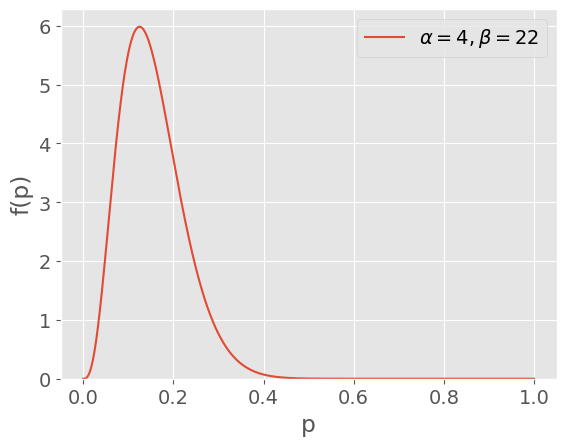

In [21]:
x = np.linspace(0,1,1000)
plt.plot(x, posterior.pdf(x), label=r"$\alpha={},\beta={}$".format(1 + k, 1 + n - k))
plt.legend()
plt.xlabel('p')
plt.ylabel('f(p)')
plt.ylim(ymin=0);

How can we use this to answer the following questions:
- what is $P(p < 0.15\ |\  \text{data})$?
- what values of $p$ bound the central 95% of this distribution?

In [22]:
posterior.cdf(0.15)

0.5288787233077632

In [23]:
posterior.ppf(0.025)

0.04537945237170958

In [24]:
posterior.ppf(0.975)

0.31219030728623537

## Bayesian A/B testing

#### Comparing two versions of the sites

Say we have two versions of our site and we want to know which has a higher click-through rate. How can we use Bayesian updating & the beta distribution for this?

We collect data for each version of the site: how many successes and failures we get for each. Suppose it's something like:

In [25]:
views_a = 2706
clicks_a = 166
failures_a = views_a - clicks_a

views_b = 2294
clicks_b = 162
failures_b = views_b - clicks_b

As before, we assume a uniform prior for the CTR for each version, then plot the posteriors.

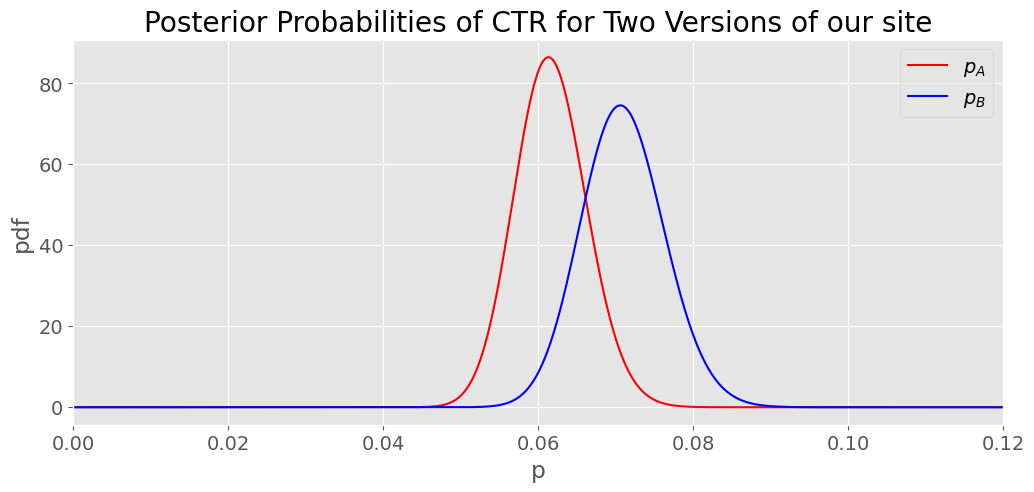

In [26]:
fig, ax = plt.subplots(figsize=(12,5))
x = np.linspace(0,1,10000)
for (a, b, s, label) in [(1 + clicks_a, 1 + failures_a,"r", "$p_A$"),
                       (1 + clicks_b, 1 + failures_b,"b", "$p_B$")]:
    # recall our formula for updating posterior
        ax.plot(x,
                stats.beta(a,b).pdf(x),
                s,
                label=label)
ax.legend(loc="upper right")
ax.set_xlabel("p")
ax.set_ylabel("pdf")
ax.set_xlim(0, 0.12)
ax.set_title("Posterior Probabilities of CTR for Two Versions of our site");

### "what is the probability that site B is better than site A?"

What is this question really asking? This whole process has been treating $p_A$ and $p_B$ as random variables whose distributions we have derived. What does it mean to ask if one random variable is larger than another?

#### Answer 1: simulation-based answer
##### (we'll cover this even deeper in week 9 with Multi-Armed Bandit and Markov-Chain Monte Carlo simulations)

In [27]:
# here are our posteriors
beta_a = stats.beta(1+clicks_a, 1+failures_a)
beta_b = stats.beta(1+clicks_b, 1+failures_b)

In [28]:
# now sample from each posterior, oh, 100000 times
samp_a = beta_a.rvs(size=100000)
samp_b = beta_b.rvs(size=100000)

In [29]:
# treat these as paired samples 
# (since they're all independent draws)
# What is the probability that the draw from beta_b 
#  is greater than the draw from beta_a?

(samp_b > samp_a).mean()

0.90704

In [30]:
samp_b > samp_a

array([ True,  True,  True, ...,  True,  True,  True])

We can ask all kinds of questions, like "what is the probability that $p_B$ is at least one percentage point higher than $p_A$?"

In [31]:
(samp_b > (samp_a + 0.01)).mean()

0.4596

#### Answer 2: analytical-ish answer

(see the real analytical answer [here.](http://www.evanmiller.org/bayesian-ab-testing.html) uses multiple integrals which can be **tough** depending on the distribution functions)

(more good reading [here](https://cdn2.hubspot.net/hubfs/310840/VWO_SmartStats_technical_whitepaper.pdf))

Since the draws of $p_A$ and $p_B$ are all **independent**, then the joint probability density function is the product of the individual pdfs:
$$ f_{p_A \& p_B}(p_A, p_B) = f_{p_A}(p_A) * f_{p_B}(p_B)$$

Let's plot it

In [32]:
x=np.linspace(0,0.15,2000)

In [33]:
prob_a = stats.beta(1+clicks_a, 1+failures_a).pdf(x)
prob_b = stats.beta(1+clicks_b, 1+failures_b).pdf(x)

In [34]:
## we're going to take advantage of a numpy trick here:
## multiplying a row vector of size m 
## by a column vector of size n
## yields an n by m array

foo = np.array([1,5,3,2])
bar = np.array([9,8]).reshape(-1,1)
print(foo)
print(bar)
print(foo*bar)

[1 5 3 2]
[[9]
 [8]]
[[ 9 45 27 18]
 [ 8 40 24 16]]


In [35]:
joint_prob_grid = prob_a * (prob_b.reshape(-1,1))
joint_prob_grid = joint_prob_grid / joint_prob_grid.sum()

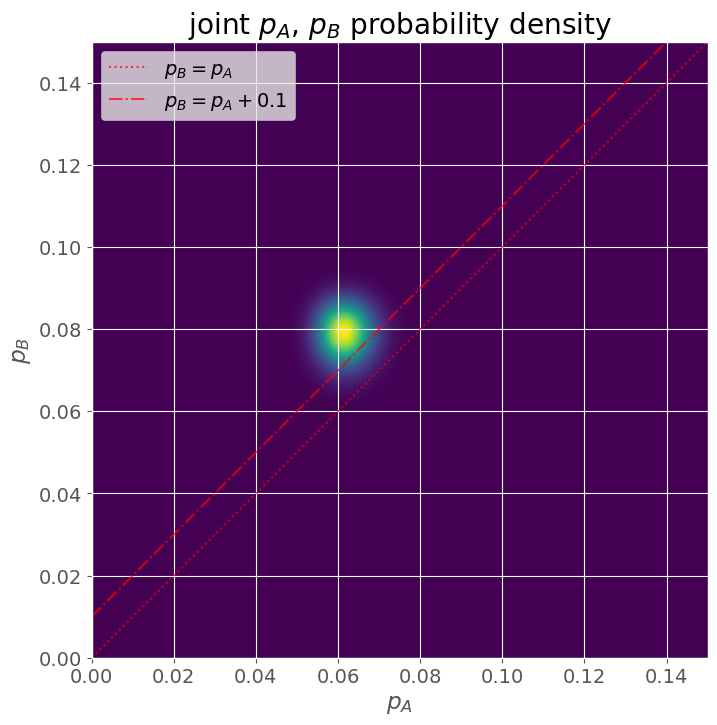

In [36]:
plt.figure(figsize=(8,8))
plt.imshow(joint_prob_grid, cmap='viridis', extent=[0,0.15,0,0.15])

plt.plot([0,.15],[0,.15], 'r:', label='$p_B = p_A$', alpha=0.7)
plt.plot([0,.15],[.01,.16], 'r-.', label='$p_B = p_A + 0.1$', alpha=0.7)

plt.ylim([0,0.15])

plt.xlabel('$p_A$')
plt.ylabel('$p_B$')
plt.title('joint $p_A$, $p_B$ probability density')
plt.legend();

So the probability of getting a pair of draws $p_A, p_B$ where $p_B > p_A$ is the area under the surface of the pdf in the region above the red dotted line.

Here's the same plot but in 3D:

In [37]:
from mpl_toolkits.mplot3d import Axes3D

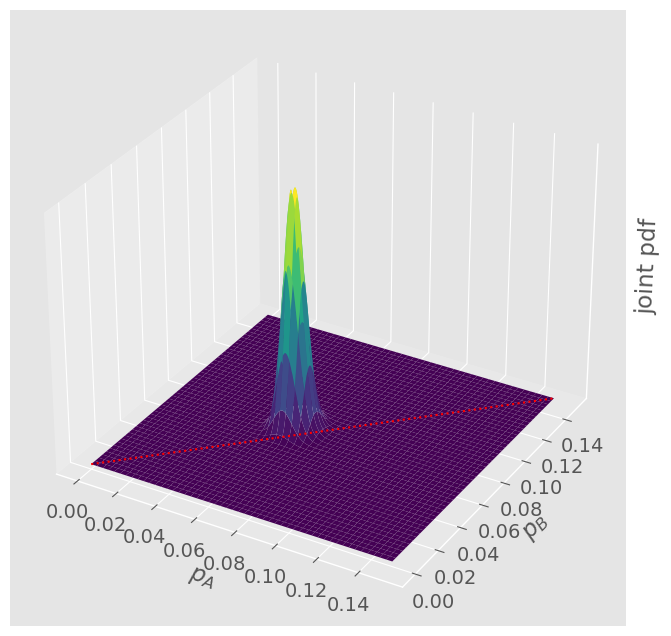

In [38]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot([0,.15],[0,.15],[0,0],'r:')

xxa, xxb = np.meshgrid(x, x)
ax.plot_surface(xxa, xxb, joint_prob_grid, cmap='viridis')
ax.set_xlabel('$p_A$')
ax.set_ylabel('$p_B$')
ax.set_zlabel('joint pdf')
ax.set_zticks([]);

And here are the approximate areas:

In [39]:
joint_prob_grid[xxb > xxa].sum()

0.9058959638795563

In [40]:
joint_prob_grid[xxb > (xxa + .01)].sum()

0.45948157085787494

# Frequentist vs. Bayesian

In both cases, we consider an ensemble of possible randomly generated universes.

Frequentist: The parameters of the data-generating process are a fixed (though unknown) reality; the observed data follows some distribution defined by those parameters.

Bayesian: The observed data is a fixed reality; our estimate of the parameters follow some random distribution.

## Frequentist A/B testing

Frequentist procedure

* Choose n (number of experiments/samples) based on expected size of effect.
* Run **all** experiments and observe the data.
* The significance is the probability of getting the result (or more extreme) assuming no effect (null hypothesis distribution).
* Doesn't tell you how likely it is that a is better than b.

## Bayesian A/B testing

Bayesian procedure

* No need to choose n beforehand.
* Update knowledge as the experiment runs.
* Gives probability of *anything you want*.

Why doesn't everyone like this better?

##### Bayesian A/B Testing Food for Thought: 

- When would we like to use analytically convenient solutions like conjugate priors? When **wouldn't** we? Hint: Think about how strong our priors are before testing and what shape they might be.
- When would we like to use simulations to "brute force" an A/B Test over using more analytical-ish methods?

## Final Words

Frequentist methods were created before modern computers. Those methods lean on limits and integrals which can be done by hand. It's from those limits and integrals that they have to take the "long run" point of view.

Bayesians still build on top of the laws of probability and the well-known distributions, but Bayesians take a different approach to how they interpret probability, which fits better with our needs (usually). Bayesians love to build layers of distributions one atop the other, using Bayes' theorem to string them all together. Once built, they  visualize the final distribution by repeated sampling, requiring a lot of computation (thank you, computers).

All scientists love data. We love data because it helps us understand the world. That's why we like the Bayesian mindset. We believe things, we collect data, and we refine our beliefs. Then we repeat that. I leave you with this final _xkcd_.

<img src="https://imgs.xkcd.com/comics/the_difference.png" width=500px>